# OPS-SAT case starter-kit notebook

ESA's [Kelvins](https://kelvins.esa.int) competition "[the OPS-SAT case](https://kelvins.esa.int/opssat/home/)" is a novel data-centric challenge that asks you to work with the raw data of a satellite and very few provided labels to find the best parameters for a given machine learning model. Compared to previous competitions on Kelvins (like the [Pose Estimation](https://kelvins.esa.int/pose-estimation-2021/) or the [Proba-V Super-resolution challenge](https://kelvins.esa.int/proba-v-super-resolution/)) where the test-set is provided and the infered results are submitted, for the OPS-SAT case, we will run inference on the Kelvins server directly! This notebooks contains examples on how you can load your data and train an **EfficientNetLite0** model by only using the 80-labeled images provided. Therefore, the directory `images`, containing unlabeld patches and included in the training dataset is not used for this notebook. However, competitors are encouraged to use these patches to improve the model accuracy.

# 1. Module imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!python3 -m pip install tensorflow==2.7

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


If you do not have a GPU, uncomment and run the next commands.


In [3]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"

Other imports.

In [4]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [5]:
tf.__version__

'2.7.0'

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [7]:
%cd drive/MyDrive/opssat/opssat_challenge

/content/drive/MyDrive/opssat/opssat_challenge


In [8]:
from efficientnet_lite import EfficientNetLiteB0

In [9]:
seed = 42

# 2. Utility Functions

You can use this function to load your training data.

In [10]:
def get_images_from_path(dataset_path):
    """ Get images from path and normalize them applying channel-level normalization. """

    # loading all images in one large batch
    tf_eval_data = tf.keras.utils.image_dataset_from_directory(dataset_path, image_size=input_shape[:2], shuffle=True, seed=seed,
                                                               batch_size=100000)

    # extract images and targets
    for tf_eval_images, tf_eval_targets in tf_eval_data:
        break

    return tf.convert_to_tensor(tf_eval_images), tf_eval_targets

In [11]:
class_mapping = {0: 'Agriculture',
                 1: 'Cloud',
                 2: 'Mountain',
                 3: 'Natural',
                 4: 'River',
                 5: 'Sea_ice',
                 6: 'Snow',
                 7: 'Water'}

In [12]:
def visualize_image(features, labels, image, pred=False, **kwargs):
    
    plt.imshow(features[image])
    
    print('Class: {}'.format(class_mapping[labels[image]]))
    
    if pred:
        predictions = kwargs.get('predictions', None)
        print('Predicted: {}'.format(class_mapping[predictions[image]]))
        
    plt.show()    

In [13]:
def evaluate_model(features, labels):
    
    predictions = np.zeros(len(labels), dtype=np.int8)
    
    for e, (image, target) in enumerate(zip(features, labels)):
        image = np.expand_dims(np.array(image), axis=0)
        output = model.predict(image)
        predictions[e] = np.squeeze(output).argmax()
    
    score_keras = 1 - metrics.cohen_kappa_score(labels.numpy(), predictions)
    print("Score:",score_keras)
    
    return predictions

In [14]:
def get_confusion_matrix(actual, predicted):
    
    actual = actual.numpy()
    predicted = predicted
    
    metrics.ConfusionMatrixDisplay.from_predictions(actual, predicted, display_labels = list(class_mapping.values()), xticks_rotation='vertical')
    
    plt.show()

# 3. Loading the model

The network architecture used for OPS-SAT is **EfficientNetLite0**. We would like to thank Sebastian for making a Keras implementation of EfficientNetLite publicly available under the Apache 2.0 License: https://github.com/sebastian-sz/efficientnet-lite-keras. Our Version of this code has been modified to better fit our purposes. For example, we removed the ReLU "stem_activation" to better match a related efficientnet pytorch implementation. In any way, **you have to use the model architecture that we provide in our [starter-kit](https://gitlab.com/EuropeanSpaceAgency/the_opssat_case_starter_kit).**

In [15]:
input_shape = (200, 200, 3)   # input_shape is (height, width, number of channels) for images
num_classes = 8
model = EfficientNetLiteB0(classes=num_classes, weights=None, input_shape=input_shape, classifier_activation=None)
model.summary()

block1a_ same
block2a_ ((1, 1), (1, 1))
block2a_ valid
block2b_ same
block3a_ ((2, 2), (2, 2))
block3a_ valid
block3b_ same
block4a_ ((1, 1), (1, 1))
block4a_ valid
block4b_ same
block4c_ same
block5a_ same
block5b_ same
block5c_ same
block6a_ ((2, 2), (2, 2))
block6a_ valid
block6b_ same
block6c_ same
block6d_ same
block7a_ same
Model: "efficientnetlite0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 201, 201, 3)  0           ['input_1[0][0]']                
                                               

# 4. Loading data

Uncomment next line and adjust with the path of your dataset. 

In [16]:
dataset_path="../ops_sat_competiton_official"

In this notebook, classical supervised learning is used. Therefore, remember to remove the subdirectory `images` containing unlabeled patches before loading the dataset to perform training correctly.

In [17]:
#Loading dataset
x_train, y_train = get_images_from_path(dataset_path)

Found 80 files belonging to 8 classes.


In [18]:
x_train.shape

TensorShape([80, 200, 200, 3])

In [19]:
y_train.shape

TensorShape([80])

In [20]:
y_train

<tf.Tensor: shape=(80,), dtype=int32, numpy=
array([6, 3, 5, 0, 2, 0, 2, 6, 0, 7, 4, 1, 1, 0, 3, 7, 3, 7, 2, 1, 1, 5,
       7, 6, 0, 5, 5, 6, 1, 2, 4, 6, 7, 7, 1, 3, 2, 5, 5, 4, 4, 6, 3, 0,
       4, 2, 1, 3, 6, 0, 3, 3, 0, 6, 6, 1, 4, 4, 7, 7, 5, 2, 2, 6, 2, 3,
       0, 7, 4, 3, 5, 0, 4, 5, 2, 4, 1, 7, 5, 1], dtype=int32)>

In [21]:
x_train = x_train.numpy().astype(np.int32)
y_train = y_train.numpy()

### Augment images

In [22]:
image_to_visualize = 18

#### Rotate images

90 degrees counterclockwise

Class: Mountain


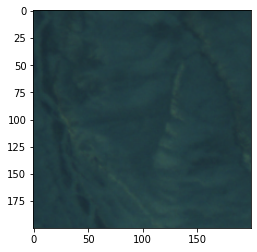

In [23]:
visualize_image(x_train, y_train, image_to_visualize)

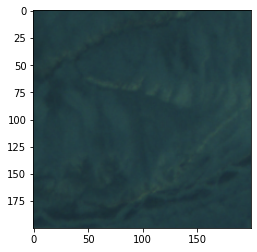

In [24]:
plt.imshow(np.rot90(x_train[image_to_visualize], k=1, axes=(0, 1)))

In [25]:
x_train_rot90_ccw = np.rot90(x_train, axes=(1,2))
x_train_rot90_ccw.shape

(80, 200, 200, 3)

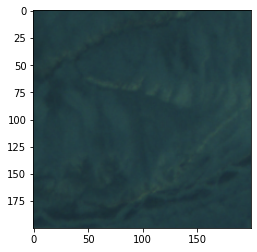

In [26]:
plt.imshow(x_train_rot90_ccw[image_to_visualize])

In [27]:
x_train_augmented = np.vstack([x_train, x_train_rot90_ccw])
x_train_augmented.shape

(160, 200, 200, 3)

In [28]:
y_train_augmented = np.concatenate([y_train, y_train])
y_train_augmented.shape

(160,)

180 degrees

Class: Mountain


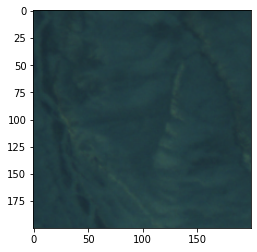

In [29]:
visualize_image(x_train, y_train, image_to_visualize)

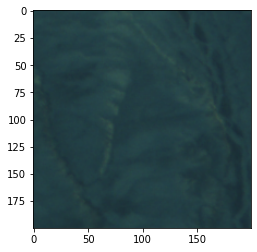

In [30]:
plt.imshow(np.rot90(np.rot90(x_train[image_to_visualize], k=1, axes=(0, 1)), k=1, axes=(0, 1)))

In [31]:
x_train_rot180 = np.rot90(np.rot90(x_train, axes=(1,2)), axes=(1,2))
x_train_rot180.shape

(80, 200, 200, 3)

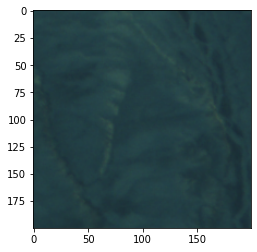

In [32]:
plt.imshow(x_train_rot180[image_to_visualize])

In [33]:
x_train_augmented = np.vstack([x_train_augmented, x_train_rot180])
x_train_augmented.shape

(240, 200, 200, 3)

In [34]:
y_train_augmented = np.concatenate([y_train_augmented, y_train])
y_train_augmented.shape

(240,)

90 degrees clockwise

Class: Mountain


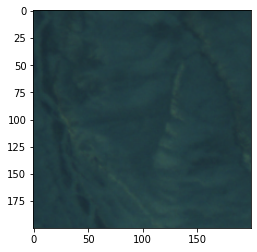

In [35]:
visualize_image(x_train, y_train, image_to_visualize)

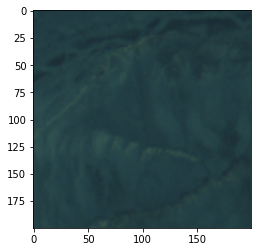

In [36]:
plt.imshow(np.rot90(x_train[image_to_visualize], k=-1, axes=(0, 1)))

In [37]:
x_train_rot90_cw = np.rot90(x_train, axes=(2,1))
x_train_rot90_cw.shape

(80, 200, 200, 3)

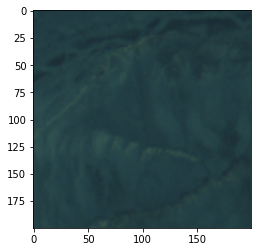

In [38]:
plt.imshow(x_train_rot90_cw[image_to_visualize])

In [39]:
x_train_augmented = np.vstack([x_train_augmented, x_train_rot90_cw])
x_train_augmented.shape

(320, 200, 200, 3)

In [40]:
y_train_augmented = np.concatenate([y_train_augmented, y_train])
y_train_augmented.shape

(320,)

#### Flip images

Up/down

Class: Mountain


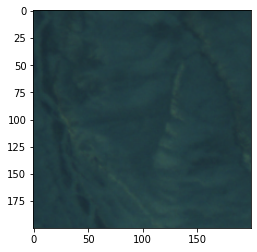

In [41]:
visualize_image(x_train, y_train, image_to_visualize)

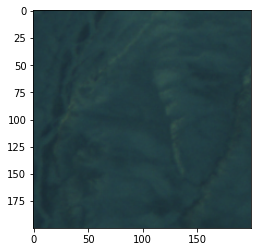

In [42]:
plt.imshow(np.flipud(x_train[image_to_visualize]))

In [43]:
x_train_flipud = np.array([np.flipud(i) for i in x_train])
x_train_flipud.shape

(80, 200, 200, 3)

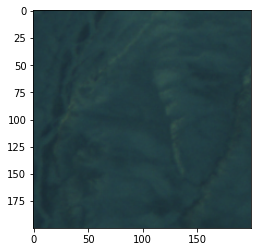

In [44]:
plt.imshow(x_train_flipud[image_to_visualize])

In [45]:
x_train_augmented = np.vstack([x_train_augmented, x_train_flipud])
x_train_augmented.shape

(400, 200, 200, 3)

In [46]:
y_train_augmented = np.concatenate([y_train_augmented, y_train])
y_train_augmented.shape

(400,)

Left/right

Class: Mountain


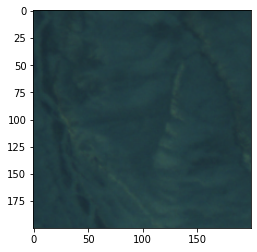

In [47]:
visualize_image(x_train, y_train, image_to_visualize)

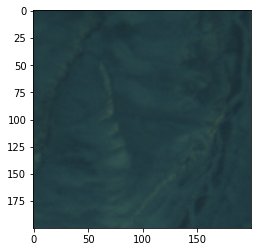

In [48]:
plt.imshow(np.fliplr(x_train[image_to_visualize]))

In [49]:
x_train_fliplr = np.array([np.fliplr(i) for i in x_train])
x_train_fliplr.shape

(80, 200, 200, 3)

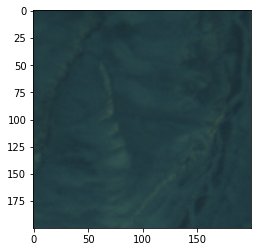

In [50]:
plt.imshow(x_train_fliplr[image_to_visualize])

In [51]:
x_train_augmented = np.vstack([x_train_augmented, x_train_fliplr])
x_train_augmented.shape

(480, 200, 200, 3)

In [52]:
y_train_augmented = np.concatenate([y_train_augmented, y_train])
y_train_augmented.shape

(480,)

#### Flip rotated images up/down

Skip the following variations since these images already exist:

- rot180 ud
- rot90 ccw lr
- rot90 cw lr

90 degrees counterclockwise up/down

Class: Mountain


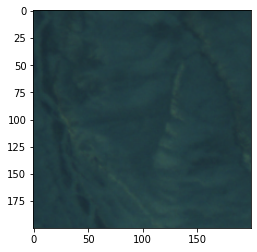

In [53]:
visualize_image(x_train, y_train, image_to_visualize)

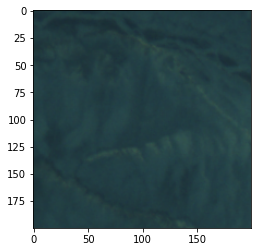

In [54]:
plt.imshow(np.flipud(x_train_rot90_ccw[image_to_visualize]))

In [55]:
x_train_rot90_ccw_flipud = np.array([np.flipud(i) for i in x_train_rot90_ccw])
x_train_rot90_ccw_flipud.shape

(80, 200, 200, 3)

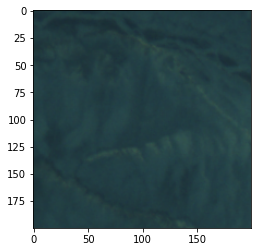

In [56]:
plt.imshow(x_train_rot90_ccw_flipud[image_to_visualize])

In [57]:
x_train_augmented = np.vstack([x_train_augmented, x_train_rot90_ccw_flipud])
x_train_augmented.shape

(560, 200, 200, 3)

In [58]:
y_train_augmented = np.concatenate([y_train_augmented, y_train])
y_train_augmented.shape

(560,)

90 degrees clockwise up/down

Class: Mountain


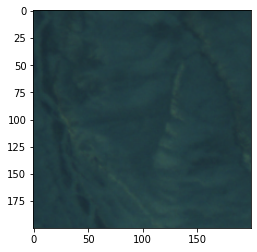

In [59]:
visualize_image(x_train, y_train, image_to_visualize)

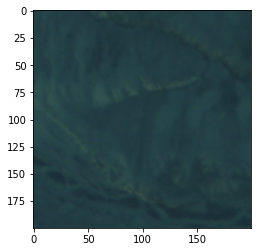

In [60]:
plt.imshow(np.flipud(x_train_rot90_cw[image_to_visualize]))

In [61]:
x_train_rot90_cw_flipud = np.array([np.flipud(i) for i in x_train_rot90_cw])
x_train_rot90_cw_flipud.shape

(80, 200, 200, 3)

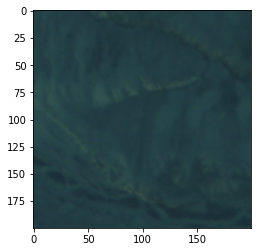

In [62]:
plt.imshow(x_train_rot90_cw_flipud[image_to_visualize])

In [63]:
x_train_augmented = np.vstack([x_train_augmented, x_train_rot90_cw_flipud])
x_train_augmented.shape

(640, 200, 200, 3)

In [64]:
y_train_augmented = np.concatenate([y_train_augmented, y_train])
y_train_augmented.shape

(640,)

#### Add Gaussian noise to images

Class: Mountain


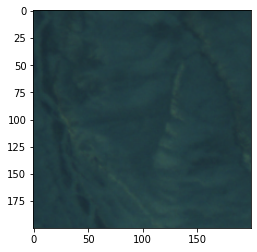

In [65]:
visualize_image(x_train, y_train, image_to_visualize)

In [66]:
np.random.seed(seed)

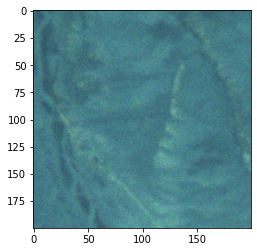

In [67]:
noise = np.random.normal(x_train[image_to_visualize], 0.1 * x_train[image_to_visualize])
noisy_image = np.round(x_train[image_to_visualize] + noise, 0).astype(np.int32)
plt.imshow(noisy_image)

In [68]:
max_index = int(round(x_train_augmented.shape[0] * 0.5, 0))
max_index

320

In [69]:
x_train_noise = np.array([np.round(i + (np.random.normal(i, 0.1 * i)), 0) for i in x_train_augmented[:max_index]]).astype(np.int32)
x_train_noise.shape

(320, 200, 200, 3)

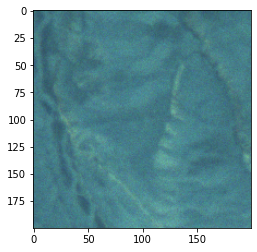

In [70]:
plt.imshow(x_train_noise[image_to_visualize])

In [71]:
x_train_augmented = np.vstack([x_train_augmented, x_train_noise])
x_train_augmented.shape

(960, 200, 200, 3)

In [72]:
y_train_augmented = np.concatenate([y_train_augmented, y_train_augmented[:max_index]])
y_train_augmented.shape

(960,)

### Random 80/20 train validation split

In [73]:
split_index = int(round(x_train_augmented.shape[0] * 0.8, 0))

x_train = tf.convert_to_tensor(x_train_augmented[:split_index])
y_train = tf.convert_to_tensor(y_train_augmented[:split_index], dtype=np.int32)

x_val = tf.convert_to_tensor(x_train_augmented[split_index:])
y_val = tf.convert_to_tensor(y_train_augmented[split_index:], dtype=np.int32)

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(768, 200, 200, 3) (768,) (192, 200, 200, 3) (192,)


# 5. Model training

We provide now an example on how you can train your model by using standard supervised learning. Training loss (`SparseCategoricalCrossentropy`) and `Accuracy` are shown for simplicity and for an easier interpretation of the training outcome, despite your submission will be evaluated by using the metric **1 - Cohen's kappa** [metric](https://en.wikipedia.org/wiki/Cohen's_kappa). For more information on scoring, please refer to [Scoring](https://kelvins.esa.int/opssat/scoring/).

In [74]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[keras.metrics.SparseCategoricalAccuracy()])

With this model and the dataset provided, please do your best!

In [75]:
tf.random.set_seed(seed)

In [76]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [77]:
%%time
# load data, data augmentation, training, overfitting, transfer-learning etc.
history=model.fit(x_train, y_train, epochs=100, verbose=1, batch_size=8, callbacks=[callback], validation_data=(x_val, y_val))

Epoch 1/100
96/96 [==============================] - 17s 94ms/step - loss: 4.5180 - sparse_categorical_accuracy: 0.1680 - val_loss: 10.4707 - val_sparse_categorical_accuracy: 0.0885
Epoch 2/100
96/96 [==============================] - 6s 65ms/step - loss: 3.2941 - sparse_categorical_accuracy: 0.1602 - val_loss: 2.7963 - val_sparse_categorical_accuracy: 0.1875
Epoch 3/100
96/96 [==============================] - 6s 60ms/step - loss: 2.9856 - sparse_categorical_accuracy: 0.1797 - val_loss: 2.5383 - val_sparse_categorical_accuracy: 0.1615
Epoch 4/100
96/96 [==============================] - 6s 59ms/step - loss: 2.6626 - sparse_categorical_accuracy: 0.2383 - val_loss: 2.6007 - val_sparse_categorical_accuracy: 0.1667
Epoch 5/100
96/96 [==============================] - 6s 59ms/step - loss: 2.5959 - sparse_categorical_accuracy: 0.2331 - val_loss: 3.3235 - val_sparse_categorical_accuracy: 0.1771
Epoch 6/100
96/96 [==============================] - 6s 59ms/step - loss: 2.3184 - sparse_categori

### Plot loss and accuracy

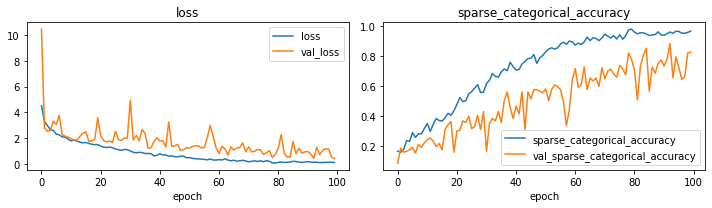

In [78]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 3))

ax0.plot(history.history['loss'], label='loss')
ax0.plot(history.history['val_loss'], label='val_loss')
ax0.set_title('loss')
ax0.set_xlabel('epoch')
ax0.legend()

ax1.plot(history.history['sparse_categorical_accuracy'], label='sparse_categorical_accuracy')
ax1.plot(history.history['val_sparse_categorical_accuracy'], label='val_sparse_categorical_accuracy')
ax1.set_title('sparse_categorical_accuracy')
ax1.set_xlabel('epoch')
ax1.legend()

plt.tight_layout()           
plt.show()

Calculating the **1 - Cohen's kappa** score of the trained model on the trained dataset.

In [79]:
%%time
predictions = evaluate_model(x_train, y_train)

Score: 0.005952415553010848
CPU times: user 35.5 s, sys: 1.23 s, total: 36.7 s
Wall time: 38.7 s


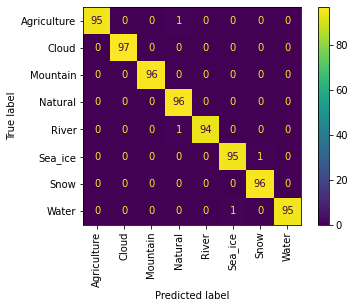

In [80]:
get_confusion_matrix(y_train, predictions)

Class: Mountain
Predicted: Mountain


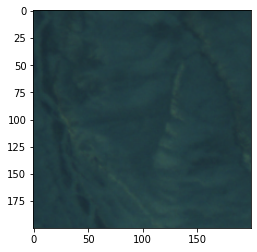

In [81]:
visualize_image(x_train.numpy().astype(int), y_train.numpy(), image_to_visualize, pred=True, predictions=predictions)

In [82]:
print('Accuracy: {:0.3f}'.format(round(metrics.accuracy_score(y_train, predictions), 3)))

# What proportion of positive identifications was actually correct?
print('Precision: {:0.3f}'.format(round(metrics.precision_score(y_train, predictions, average='micro'), 3)))

# What proportion of actual positives was identified correctly?
print('Recall: {:0.3f}'.format(round(metrics.recall_score(y_train, predictions, average='micro'), 3)))

print('F1-Score: {:0.3f}'.format(round(metrics.f1_score(y_train, predictions, average='micro'), 3)))

print(metrics.classification_report(y_train, predictions))

Accuracy: 0.995
Precision: 0.995
Recall: 0.995
F1-Score: 0.995
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        96
           1       1.00      1.00      1.00        97
           2       1.00      1.00      1.00        96
           3       0.98      1.00      0.99        96
           4       1.00      0.99      0.99        95
           5       0.99      0.99      0.99        96
           6       0.99      1.00      0.99        96
           7       1.00      0.99      0.99        96

    accuracy                           0.99       768
   macro avg       0.99      0.99      0.99       768
weighted avg       0.99      0.99      0.99       768



### Evaluation on val set

In [83]:
%%time
predictions = evaluate_model(x_val, y_val)

Score: 0.19643466129282283
CPU times: user 7.92 s, sys: 311 ms, total: 8.23 s
Wall time: 8.06 s


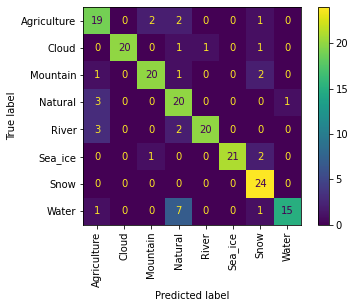

In [84]:
get_confusion_matrix(y_val, predictions)

Class: Agriculture
Predicted: Mountain


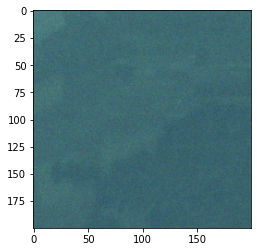

In [85]:
visualize_image(x_val.numpy().astype(int), y_val.numpy(), image_to_visualize, pred=True, predictions=predictions)

In [86]:
print('Accuracy: {:0.3f}'.format(round(metrics.accuracy_score(y_val, predictions), 3)))

# What proportion of positive identifications was actually correct?
print('Precision: {:0.3f}'.format(round(metrics.precision_score(y_val, predictions, average='micro'), 3)))

# What proportion of actual positives was identified correctly?
print('Recall: {:0.3f}'.format(round(metrics.recall_score(y_val, predictions, average='micro'), 3)))

print('F1-Score: {:0.3f}'.format(round(metrics.f1_score(y_val, predictions, average='micro'), 3)))

print(metrics.classification_report(y_val, predictions))

Accuracy: 0.828
Precision: 0.828
Recall: 0.828
F1-Score: 0.828
              precision    recall  f1-score   support

           0       0.70      0.79      0.75        24
           1       1.00      0.87      0.93        23
           2       0.87      0.83      0.85        24
           3       0.61      0.83      0.70        24
           4       0.95      0.80      0.87        25
           5       1.00      0.88      0.93        24
           6       0.77      1.00      0.87        24
           7       0.94      0.62      0.75        24

    accuracy                           0.83       192
   macro avg       0.86      0.83      0.83       192
weighted avg       0.86      0.83      0.83       192



# 6. Saving and loading trained model

The trained model can be now saved by using HDF5-format that is the only accepted for submission. The name `test.h5` will be used.

In [87]:
#Saving model
model.save_weights('v22.h5')

The trained model can be also loaded for further testing. 

In [88]:
#model = EfficientNetLiteB0(classes=num_classes, weights=None, input_shape=input_shape, classifier_activation=None)
model.load_weights('v22.h5')

The model will be now compiled and tested again. You should get the same score as before saving and loading. 

In [89]:
#Model shall be compiled before testing.
model.compile()

predictions = evaluate_model(x_train, y_train)

Score: 0.005952415553010848


In [90]:
!time python train.py

2022-09-30 21:23:50.283968: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
block1a_ same
block2a_ ((1, 1), (1, 1))
block2a_ valid
block2b_ same
block3a_ ((2, 2), (2, 2))
block3a_ valid
block3b_ same
block4a_ ((1, 1), (1, 1))
block4a_ valid
block4b_ same
block4c_ same
block5a_ same
block5b_ same
block5c_ same
block6a_ ((2, 2), (2, 2))
block6a_ valid
block6b_ same
block6c_ same
block6d_ same
block7a_ same
Found 80 files belonging to 8 classes.
2022-09-30 21:23:52.679562: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 384000000 exceeds 10% of free system memory.
2022-09-30 21:23:53.198205: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 460800000 exceeds 10% of free system memory.
2022-09-30 21:23:54.052733: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 537600000 exceeds 10% of free sys